In [2]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize, fsolve
from scipy.special import roots_legendre
import scipy.linalg as la
import matplotlib.pyplot as plt
from FEM_1D import *
from tools import *
from shape_functions import *
plt.style.use('default')
import copy
fontsize = 15

(72.0, 67.0)
Shape class: linear, Number of elements: 3, Polynomial order:1,  Domain: (0, 1), Boundary conditions: (72.0, 67.0)


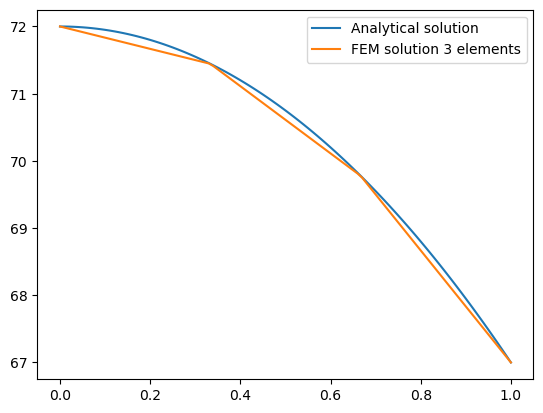

In [6]:
num_elems = 3
domain = (0, 1)
p = 1
mesh = np.linspace(domain[0], domain[1], num_elems+1)
a = .5*1
xb = 0.8
if a == 50:
    U_init = 1.585854059271320
elif a == 0.5:
    U_init = 0.03559183822564316
exact_func = exact_fn(a = a, xb=xb)
rhs_func = rhs_fn(a=a, xb=xb)
BCs = (exact_func(domain[0]), exact_func(domain[-1]))
print(BCs)
U_l_test, phi_phip_l_test, uh_l_test, cont_K_l_test = FEM_1D(shape_class = linear,p=p, num_elems = num_elems, domain = domain,rhs_func = rhs_func,exact_func=exact_func, BCs = BCs, verbose = True)
# cal_energy(U_l_test, phi_phip_l_test)

In [29]:
import numpy as np
def exact_solution(r, A0=71, muJz=20):
    return A0 - 1/4 * muJz * r**2

# # 随机从0到1之间抽取r的值
r = np.random.uniform(0, 1, size=(1000, 1))  # 假设我们需要1000个样本

# 使用exact_solution函数计算对应的解
A0 = 71
muJz = 20
exact_solution_values = exact_solution(r, A0, muJz)
# 将r和对应的解保存到npy文件中
np.savez("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/datasets/Poission.npz", r=r, solution=exact_solution_values)



In [54]:
import numpy as np

def gen_traindata(num):
    # 更新为实际的文件路径
    data = np.load("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/datasets/Poission.npz")
    r = data["r"]  # 假设r在第一列
    solution = data["solution"]  # 假设solution在第二列

    # 生成随机索引
    indices = np.random.choice(r.shape[0], size=num, replace=False)
    
    # 使用随机索引选择数据
    return r[indices], solution[indices]

# 示例使用
num_samples = 10  # 你想要抽取的样本数量
ob_x, ob_u = gen_traindata(num_samples)
# print(ob_x, ob_u)  # 输出抽取的数据的形状


[[0.07382663]
 [0.8545852 ]
 [0.62372856]
 [0.15576085]
 [0.9863937 ]
 [0.75763961]
 [0.04304347]
 [0.1935078 ]
 [0.1286304 ]
 [0.13592847]] [[70.97274814]
 [67.34842068]
 [69.05481344]
 [70.87869279]
 [66.13513735]
 [68.12991107]
 [70.9907363 ]
 [70.81277367]
 [70.91727109]
 [70.90761726]]


In [56]:

def gen_traindata():
    # 更新为实际的文件路径
    data = np.load("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/datasets/Poission.npz")
    return data["r"], data["solution"]

def sol(x):
    # solution is u(x) = sin(pi*x), q(x) = -pi^2 * sin(pi*x)
    return np.sin(np.pi * x)


data = gen_traindata()
# data[0]


In [58]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("default")


def gen_traindata(num=100):
    # 更新为实际的文件路径
    data = np.load("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/datasets/Poission.npz")
    r = data["r"]  # 假设r在第一列
    solution = data["solution"]  # 假设solution在第二列

    # 生成随机索引
    indices = np.random.choice(r.shape[0], size=num, replace=False)
    
    # 使用随机索引选择数据
    return r[indices], solution[indices]

K = dde.Variable(20)

def pde(x, y):
    u, q = y[:, 0:1], y[:, 1:2]
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    dA_z_dr  = dde.grad.jacobian(x*du_dx, x, i=0, j=0)
    return dA_z_dr/x + q


def sol(x):
    A0 = 71
    muJz = 20
    return A0 - 1/4 * muJz * x**2


geom = dde.geometry.Interval(-1, 1)

left_bc = dde.icbc.DirichletBC(geom, lambda x: 71, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0), component=0)

right_bc = dde.icbc.DirichletBC(geom, lambda x: 66, lambda x, on_boundary: on_boundary and np.isclose(x[0], 1), component=0)

neumann_bc = dde.icbc.NeumannBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0), component=0)

ob_x, ob_u = gen_traindata()
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

data = dde.data.PDE(
    geom,
    pde,
    [left_bc, right_bc, neumann_bc, observe_u],  # 包括所有边界条件和观测点边界条件
    num_domain=200,
    num_boundary=2,
    anchors=ob_x,
    num_test=1000,
)

neurons = 100
net = dde.nn.PFNN([1, [neurons, neurons], [neurons, neurons], [neurons, neurons], 2], "tanh", "Glorot uniform")

model = dde.Model(data, net)
model.compile("adam", lr=0.0001, loss_weights=[1, 100, 1000])
losshistory, train_state = model.train(iterations=200)
print(losshistory)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# view results
x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, qhat = yhat[:, 0:1], yhat[:, 1:2]

utrue = sol(x)
print("l2 relative error for u: " + str(dde.metrics.l2_relative_error(utrue, uhat)))
plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()

qtrue = -np.pi ** 2 * np.sin(np.pi * x)
print("l2 relative error for q: " + str(dde.metrics.l2_relative_error(qtrue, qhat)))
plt.figure()
plt.plot(x, qtrue, "-", label="q_true")
plt.plot(x, qhat, "--", label="q_NN")
plt.legend()

plt.show()

Compiling model...
'compile' took 0.000789 s

Training model...



RuntimeError: The size of tensor a (5) must match the size of tensor b (3) at non-singleton dimension 0

In [59]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("default")

def gen_traindata(num):
    # generate num equally-spaced points from -1 to 1
    xvals = np.linspace(-1, 1, num).reshape(num, 1)
    uvals = np.sin(np.pi * xvals)
    return xvals, uvals
data = gen_traindata(2)
data[1]

array([[-1.2246468e-16],
       [ 1.2246468e-16]])

Compiling model...
'compile' took 0.000770 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.90e-03, 3.03e+00, 3.79e+02]    [5.95e-03, 3.03e+00, 3.79e+02]    []  
20        [4.04e-03, 6.56e+00, 3.36e+02]    [4.07e-03, 6.56e+00, 3.36e+02]    []  

Best model at step 20:
  train loss: 3.42e+02
  test loss: 3.42e+02
  test metric: []

'train' took 0.067070 s

Saving loss history to /Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/loss.dat ...
Saving training data to /Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/train.dat ...
Saving test data to /Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/test.dat ...


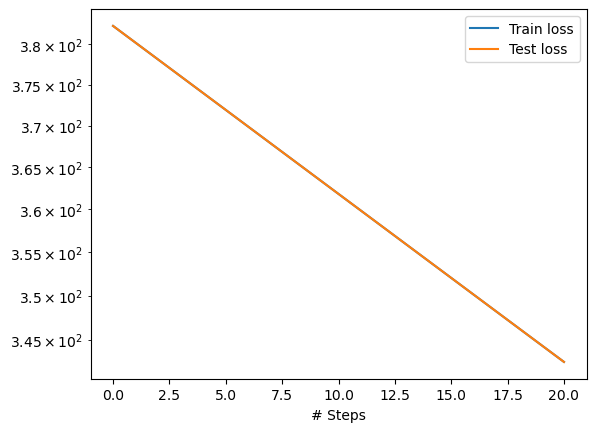

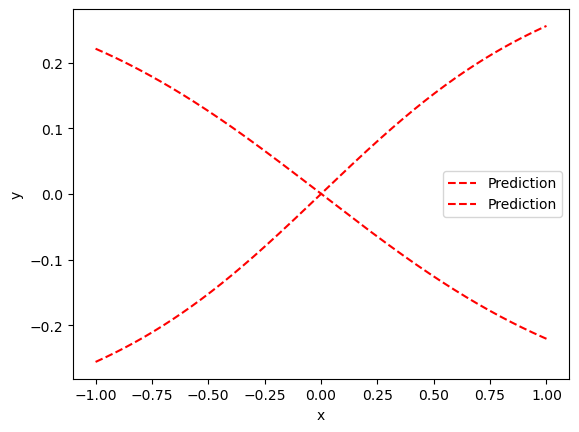

l2 relative error for u: 0.8230881
l2 relative error for q: 0.9842025


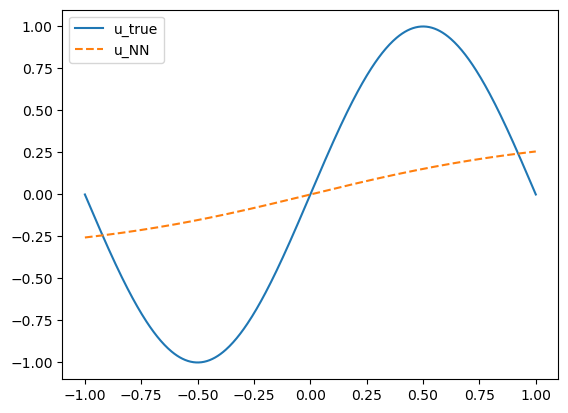

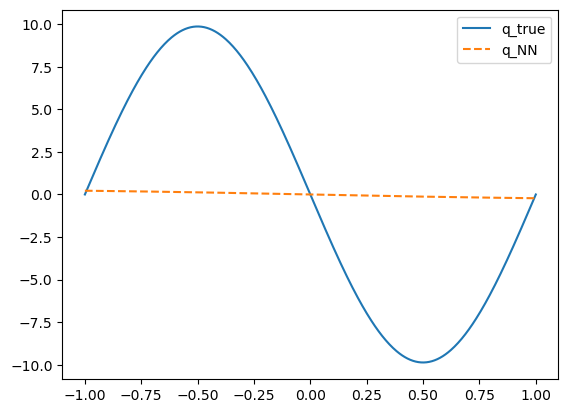

In [60]:


def pde(x, y):
    u, q = y[:, 0:1], y[:, 1:2]
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return -du_xx + q


def sol(x):
    # solution is u(x) = sin(pi*x), q(x) = -pi^2 * sin(pi*x)
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)

bc = dde.icbc.DirichletBC(geom, sol, lambda _, on_boundary: on_boundary, component=0)
ob_x, ob_u = gen_traindata(100)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

data = dde.data.PDE(
    geom,
    pde,
    [bc, observe_u],
    num_domain=200,
    num_boundary=2,
    anchors=ob_x,
    num_test=1000,
)

net = dde.nn.PFNN([1, [20, 20], [20, 20], [20, 20], 2], "tanh", "Glorot uniform")

model = dde.Model(data, net)
model.compile("adam", lr=0.0001, loss_weights=[1, 100, 1000])
losshistory, train_state = model.train(iterations=20)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# view results
x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, qhat = yhat[:, 0:1], yhat[:, 1:2]

utrue = np.sin(np.pi * x)
print("l2 relative error for u: " + str(dde.metrics.l2_relative_error(utrue, uhat)))
plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()

qtrue = -np.pi ** 2 * np.sin(np.pi * x)
print("l2 relative error for q: " + str(dde.metrics.l2_relative_error(qtrue, qhat)))
plt.figure()
plt.plot(x, qtrue, "-", label="q_true")
plt.plot(x, qhat, "--", label="q_NN")
plt.legend()

plt.show()

In [67]:
def FEM_1D(domain = (0, 1), interfaces = [ 0, .25, .5, .75, 1], num_elems = 3):
    N=3
    num_elems_per_segment = num_elems
    num_elems = len(interfaces) * num_elems_per_segment
    # 初始化网格数组
    mesh = np.array([])

    # 遍历界面列表，为每个子区间生成网格
    for i in range(len(interfaces)-1):
        # 当前子区间的起始点和结束点
        start, end = interfaces[i], interfaces[i+1]

        # 在当前子区间内生成等间距的节点
        # np.linspace包括区间的起始和结束点，但为避免重复添加界面节点，我们从第二个节点开始添加（当i不为0时）
        sub_mesh = np.linspace(start, end, num_elems_per_segment + 1)
        if i > 0:
            sub_mesh = sub_mesh[1:]  # 移除子网格的第一个节点，因为它是上一个子网格的最后一个节点

        # 将子网格添加到总网格中
        mesh = np.concatenate((mesh, sub_mesh))
    return mesh

mesh = FEM_1D()
mesh

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        ])